In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install --upgrade xlrd
from sklearn.linear_model import LinearRegression

import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show

from collections import defaultdict

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [2]:
year_month = []
free_popul_sum = []


target_dir = "/content/drive/MyDrive/DL_data/DACON6/지하철 이용 정보/교통카드 통계자료/"

fname_list = os.listdir("/content/drive/MyDrive/DL_data/DACON6/지하철 이용 정보/교통카드 통계자료")
fname_list.sort(reverse=False)

for folder in fname_list:
    excel_list = os.listdir(target_dir+folder)
    excel_list.sort(reverse=False)
    for fname in excel_list:
        try:
            df = pd.read_excel(target_dir+folder+'/'+fname, sheet_name="지하철 유무임별 이용현황")
        except:
            print(folder, fname, ': "지하철 유무임별 이용현황" sheet not found')
            continue
        df['무임승차'] = df['무임승차'].str.replace(',', '').astype(float)
        df['무임하차'] = df['무임하차'].str.replace(',', '').astype(float)

        # 무임하차 집계인원보다는 무임승차 집계인원이, 무임승차자 수와의 연관성이 높다고 판단하여 무임승차 인원으로 이용자 수 추정
        sum_fride = df['무임승차'].sum()

        year_month.append(df['사용월'][0])
        free_popul_sum.append(sum_fride)

# 2015년 4월 무임승차 정보 제거 // 무임승차인원 첫 조사 시행 달이라 오류가 있던 것으로 판단 - 무임승차인원이 다른 달에 비해 현격하게 큼
year_month = year_month[1:]
free_popul_sum = free_popul_sum[1:]

2015 2015년 01월  교통카드 통계자료.xls : "지하철 유무임별 이용현황" sheet not found
2015 2015년 02월  교통카드 통계자료.xls : "지하철 유무임별 이용현황" sheet not found
2015 2015년 03월  교통카드 통계자료.xls : "지하철 유무임별 이용현황" sheet not found


In [3]:
free_riders = defaultdict(list)

for i in range(len(year_month)):
    free_riders[year_month[i][:4]].append(free_popul_sum[i])

year = []
year_frider = []

for key in free_riders.keys():
    year.append(key)
    year_frider.append((sum(free_riders[key]) / len(free_riders[key]))*12)

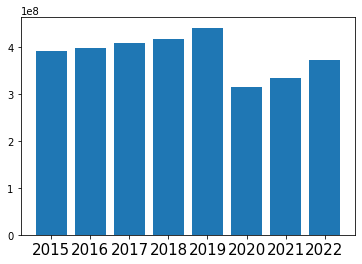

In [4]:
plt.bar(range(len(year)), year_frider)
plt.xticks(range(len(year)), year, fontsize=15)
plt.title('')
plt.show()

# 2020년 코로나로 인한 지하철 이용인원 감소

In [5]:
# 2015 - 2019 증가율을 바탕으로, 2022년부터 linear regression 적용
# Hypothesis : 2022년 이후 서울시는 코로나 사태 이후 안정기에 들어갔으므로, 기존 경향성을 유지한다.

line_fitter = LinearRegression()
line_fitter.fit(np.arange(5).reshape(-1,1), year_frider[:5])

print('절편 :', line_fitter.intercept_)
print('회귀 계수(기울기) :', line_fitter.coef_)

# linear regression 절편을 2022년 데이터에 fit하도록 맞춤

gap = line_fitter.predict([[7]])[0] - year_frider[7]

line_fitter.intercept_ = line_fitter.intercept_ - gap

절편 : 388500497.5
회귀 계수(기울기) : [11778196.8]


In [6]:
for y in range(2023, 2031):
    year.append(str(y))
    year_frider.append(line_fitter.predict([[y-2015]])[0])

print(year)
print(year_frider)

['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
[392927374.5, 397912456.0, 409775569.0, 417788939.0, 441880117.0, 315383439.0, 335194905.0, 372105052.0, 383883248.79999995, 395661445.59999996, 407439642.4, 419217839.2, 430996036.0, 442774232.79999995, 454552429.6, 466330626.4]


In [9]:
df = pd.DataFrame(zip(year, year_frider), columns=['연도', '무임승차 인원'])

df['예측'] = [False]*8 + [True]*8 # 2015~2022는 실제 데이터, 2023~2030은 예측 데이터

df

,연도,무임승차 인원,예측
0,2015,392927374.5,False
1,2016,397912456.0,False
2,2017,409775569.0,False
3,2018,417788939.0,False
4,2019,441880117.0,False
5,2020,315383439.0,False
6,2021,335194905.0,False
7,2022,372105052.0,False
8,2023,383883248.8,True
9,2024,395661445.6,True


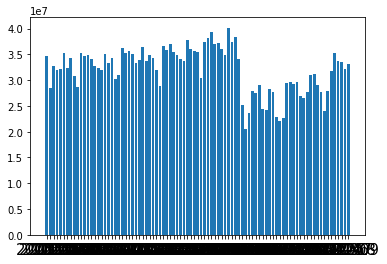

In [30]:
plt.bar(range(len(year_month)), free_popul_sum)
plt.xticks(range(len(year_month)), year_month, fontsize=15)
plt.show()